In [1]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from nltk.corpus import stopwords
import string
import preprocessor as p
from ekphrasis.classes.segmenter import Segmenter
from gensim.parsing.preprocessing import remove_stopwords

stop_words = set(stopwords.words('english'))

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('../data/tweets.csv')

In [4]:
df.rename(columns={"tweet_text": "tweet", "emotion_in_tweet_is_directed_at": "product", "is_there_an_emotion_directed_at_a_brand_or_product": "sentiment"}, inplace=True)

In [5]:
df['sentiment'].value_counts().to_frame()

,sentiment
No emotion toward brand or product,5156
Positive emotion,2869
Negative emotion,545
I can't tell,151


In [6]:
df['product'].value_counts().to_frame()

,product
iPad,910
Apple,640
iPad or iPhone App,451
Google,412
iPhone,288
Other Google product or service,282
Android App,78
Android,74
Other Apple product or service,34


In [8]:
df.groupby(['sentiment','product']).count()

tweet
sentiment                          product                               
I can't tell                       Apple                                2
                                   Google                               1
                                   Other Google product or service      1
                                   iPad                                 4
                                   iPhone                               1
Negative emotion                   Android                              8
                                   Android App                          7
                                   Apple                               92
                                   Google                              63
                                   Other Apple product or service       2
                                   Other Google product or service     46
                                   iPad                               120
                                   iPad or iPhone App                  60
                                   iPhone                              98
No emotion toward brand or product Android                              1
                                   Android App                          1
                                   Apple                               20
                                   Google                              14
                                   Other Apple product or service       1
                                   Other Google product or service      9
                                   iPad                                22
                                   iPad or iPhone App                  10
                                   iPhone                               9
Positive emotion                   Android                             65
                                   Android App                         70
                                   Apple                              526
                                   Google                             334
                                   Other Apple product or service      31
                                   Other Google product or service    226
                                   iPad                               764
                                   iPad or iPhone App                 381
                                   iPhone                             180

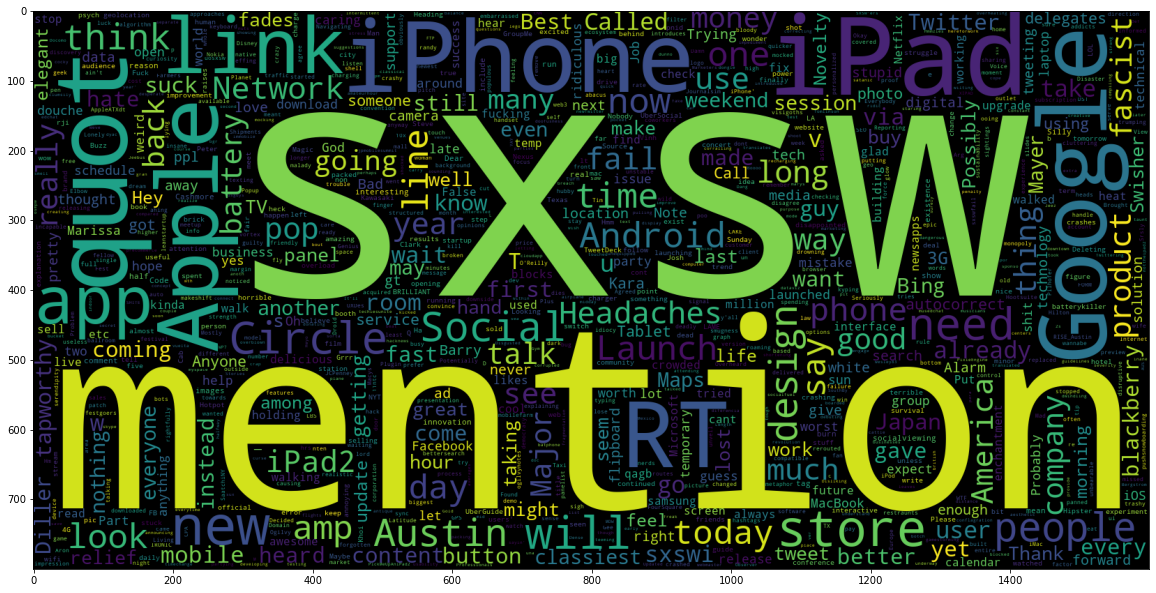

In [9]:
data_neg = df[df['sentiment'] =='Negative emotion']
data_neg = data_neg['tweet']
plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))

plt.imshow(wc);

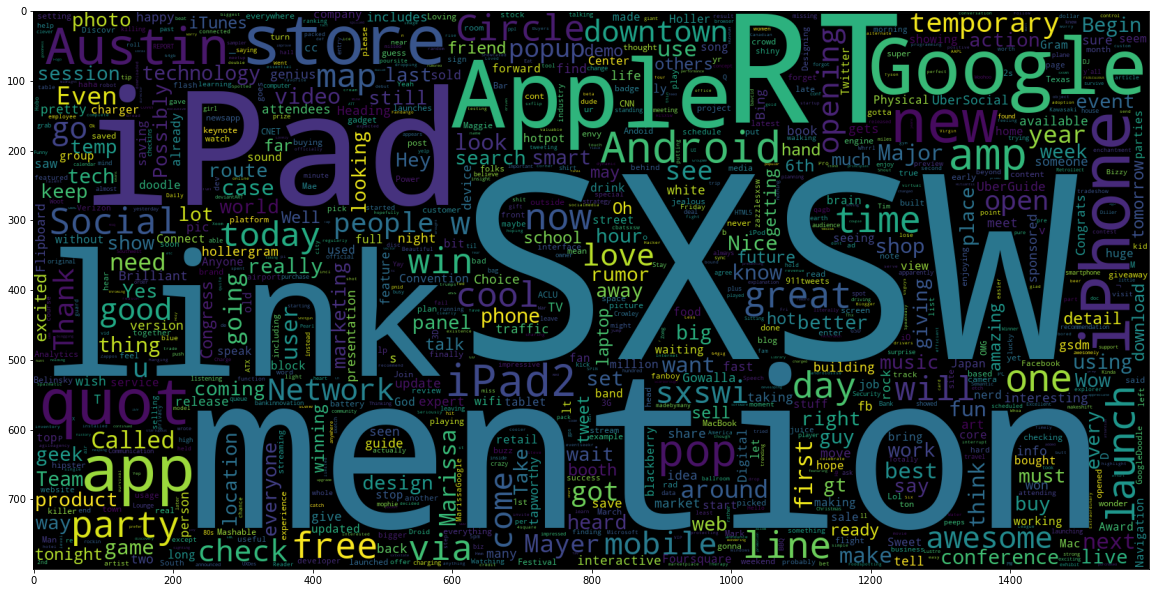

In [72]:
data_neg = df[df['sentiment'] =='Positive emotion']
data_neg = data_neg['tweet']
plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))

plt.imshow(wc);

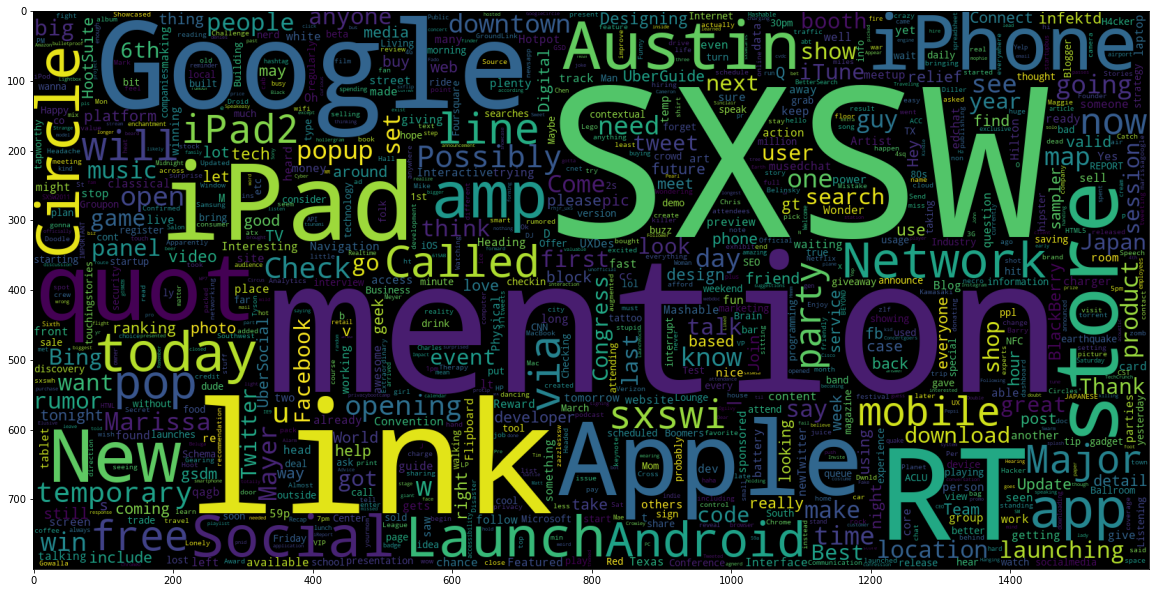

In [73]:
data_neg = df[df['sentiment'] =='No emotion toward brand or product']
data_neg = data_neg['tweet']
plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))

plt.imshow(wc);

In [6]:
df['tweet'] = df['tweet'].astype(str)

In [65]:
corpus=[]
new= df['tweet'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict

dic=defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word]+=1

In [66]:
top25 = sorted(dic.items(), key=lambda item: item[1], reverse=True)[:25]

/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


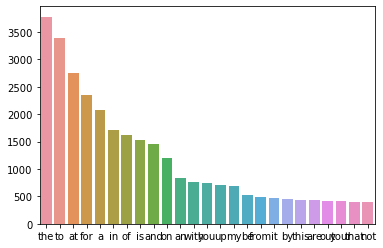

In [67]:
x_val = [x[0] for x in top25]
y_val = [x[1] for x in top25]

sns.barplot(x_val,y_val);

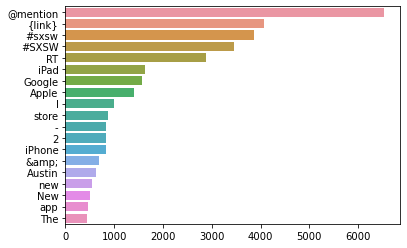

In [71]:
import collections

counter=collections.Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop_words):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x);

<AxesSubplot:xlabel='tweet', ylabel='Count'>

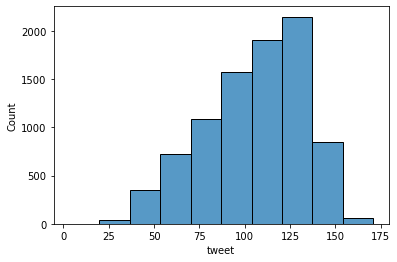

In [82]:
sns.histplot(df['tweet'].str.len(), bins=10)

<AxesSubplot:xlabel='tweet', ylabel='Count'>

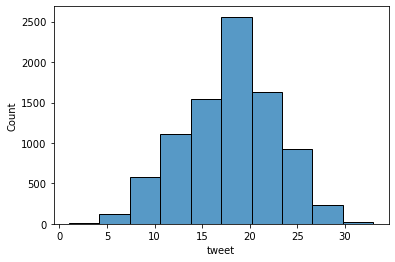

In [81]:
sns.histplot(df['tweet'].str.split().map(lambda x: len(x)), bins=10)


In [83]:
from nltk.util import ngrams

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot:>

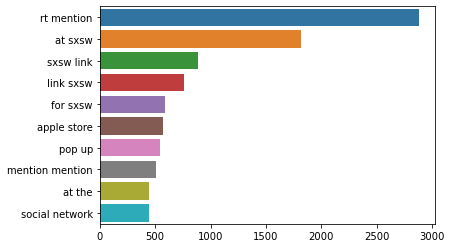

In [88]:
from sklearn.feature_extraction.text import CountVectorizer
top_bi_grams=get_top_ngram(df['tweet'],n=2)
x,y=map(list,zip(*top_bi_grams))
sns.barplot(x=y,y=x)

<AxesSubplot:>

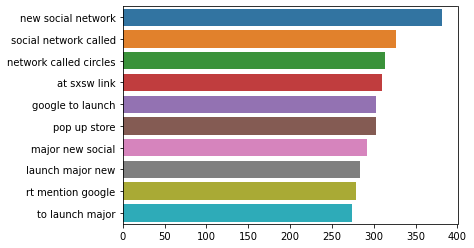

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
top_tri_grams=get_top_ngram(df['tweet'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

# Preprocess

In [10]:
#Create a column for the hashtags
df['hashtag'] = df['tweet'].apply(lambda x: re.findall(r"#(\w+)", str(x)))

In [11]:
df['tweet'] = df['tweet'].astype(str)

In [12]:
def preprocess_tweet_text(tweet):
    # Lowercase
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
    #Return the words joined back together
    return " ".join(lemma_words)

In [13]:
df['tweet'] = df['tweet'].apply(preprocess_tweet_text)

In [14]:
df.head()

,tweet,product,sentiment,hashtag
0,3g iphone 3 hrs tweeting riseaustin dead need ...,iPhone,Negative emotion,"[RISE_Austin, SXSW]"
1,know awesome ipadiphone app youll likely appre...,iPad or iPhone App,Positive emotion,[SXSW]
2,wait ipad 2 also sale sxsw,iPad,Positive emotion,"[iPad, SXSW]"
3,hope years festival isnt crashy years iphone a...,iPad or iPhone App,Negative emotion,[sxsw]
4,great stuff fri sxsw marissa mayer google tim ...,Google,Positive emotion,[SXSW]


# Vectorize

In [17]:
#Remove tweets with "I can't tell" sentiment
df = df[df.sentiment != "I can't tell"]

In [19]:
# Convert string labels to 0,1,2
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['target'] = le.fit_transform(df['sentiment'])

<ipython-input-19-6429adb43d69>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = le.fit_transform(df['sentiment'])


#### 0 = Negative, 1 = Neutral, 2 = Positive

In [25]:
# Separate features and labels 
X = df['tweet']
y = df['target']

In [26]:
# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [27]:
#Instantiate TFIDF vectorizer
vectorizer = TfidfVectorizer()
#Fit transform training data
tf_idf_train = vectorizer.fit_transform(X_train)
#Transform test data
tf_idf_test = vectorizer.transform(X_test)

# Modeling - FSM

In [30]:
#Start with a classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)
#fit on training data
classifier.fit(tf_idf_train, y_train)
#get predictions
y_preds_train = classifier.predict(tf_idf_train)
y_preds_test = classifier.predict(tf_idf_test)

## Predictions using training data

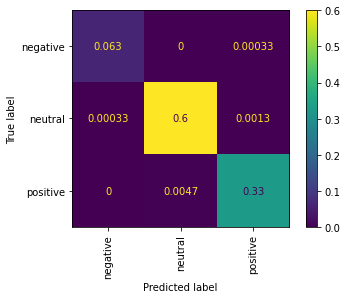

In [34]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report 

plot_confusion_matrix(classifier, tf_idf_train, y_train, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

In [36]:
print(classification_report(y_train, y_preds_train, target_names = ['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99       378
     neutral       0.99      1.00      0.99      3620
    positive       0.99      0.99      0.99      2001

    accuracy                           0.99      5999
   macro avg       0.99      0.99      0.99      5999
weighted avg       0.99      0.99      0.99      5999



## Predictions using test data

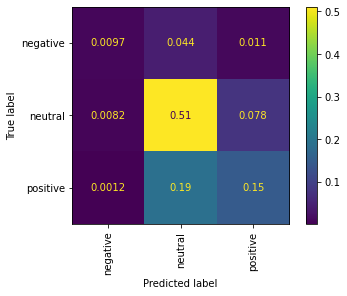

In [37]:
plot_confusion_matrix(classifier, tf_idf_test, y_test, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

In [38]:
print(classification_report(y_test, y_preds_test, target_names = ['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.51      0.15      0.23       167
     neutral       0.69      0.86      0.76      1536
    positive       0.62      0.44      0.51       868

    accuracy                           0.67      2571
   macro avg       0.61      0.48      0.50      2571
weighted avg       0.65      0.67      0.64      2571



# Tuning 

In [80]:
from imblearn.pipeline import Pipeline
import time
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE

# TFIDF pipeline setup

# Naive Bayes pipeline setup
tvc_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('SMOTE',SMOTE(sampling_strategy = 'minority', random_state=42)),
 ('mb', MultinomialNB())
])

# Randomforest pipeline setup
rf_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state=42)),
 ('rf', RandomForestClassifier())
])

# Fit
tvc_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

# Setting params for TFIDF Vectorizer gridsearch
tf_params = {
 'tvec__max_features':[100, 500, 1000, 2000],
 'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'tvec__stop_words': ['english']
}

# Setting up randomforest params
rf_params = {
 'tvec__max_features':[500, 1000, 2000],
 'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'tvec__stop_words': ['english'],
 'rf__max_depth': [500, 1000],
 'rf__min_samples_split': [50,100]
}

In [81]:
start = time.time()

# Setting up GridSearch for Randomforest
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv = 5, verbose = 1, n_jobs = -1)

# Setting up GridSearch for TFIDFVectorizer
tvc_gs = GridSearchCV(tvc_pipe, param_grid=tf_params, cv = 5, verbose =1, n_jobs = -1)

# Fitting TVC GS
tvc_gs.fit(X_train, y_train)

# Fitting Randomforest CV GS
rf_gs.fit(X_train, y_train)

end = time.time()
print('Time it took to run the fittings: {}'.format(round(end-start),0) + ' seconds')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   44.3s finished


Time it took to run the fittings: 49 seconds


In [62]:
# Scoring Training data on TFIDFVectorizer
print('Training score for Naive Bayes: {}'.format(tvc_gs.score(X_train, y_train)))

# Scoring Test data on TFIDFVectorizer
print('Testing score for Naive Bayes: {}'.format(tvc_gs.score(X_test, y_test)))

# Scoring Training data on RandomForest
print('Training score for Random Forest: {}'.format(rf_gs.score(X_train, y_train)))

# Checking Test score on RandomForest
print('Testing score for Random Forest: {}'.format(rf_gs.score(X_test, y_test)))

Training score for Naive Bayes: 0.744790798466411
Testing score for Naive Bayes: 0.6721120186697783
Training score for Random Forest: 0.8948158026337723
Testing score for Random Forest: 0.6713341112407624


In [69]:
# Scoring Training data on TFIDFVectorizer
print('Training score for Naive Bayes: {}'.format(tvc_gs.score(X_train, y_train)))

# Scoring Test data on TFIDFVectorizer
print('Testing score for Naive Bayes: {}'.format(tvc_gs.score(X_test, y_test)))

# Scoring Training data on RandomForest
print('Training score for Random Forest: {}'.format(rf_gs.score(X_train, y_train)))

# Checking Test score on RandomForest
print('Testing score for Random Forest: {}'.format(rf_gs.score(X_test, y_test)))

Training score for Naive Bayes: 0.7462910485080847
Testing score for Naive Bayes: 0.6705562038117464
Training score for Random Forest: 0.9256542757126188
Testing score for Random Forest: 0.6783352781019059


In [75]:
# Scoring Training data on TFIDFVectorizer
print('Training score for Naive Bayes: {}'.format(tvc_gs.score(X_train, y_train)))

# Scoring Test data on TFIDFVectorizer
print('Testing score for Naive Bayes: {}'.format(tvc_gs.score(X_test, y_test)))

# Scoring Training data on RandomForest
print('Training score for Random Forest: {}'.format(rf_gs.score(X_train, y_train)))

# Checking Test score on RandomForest
print('Testing score for Random Forest: {}'.format(rf_gs.score(X_test, y_test)))

Training score for Naive Bayes: 0.7007834639106518
Testing score for Naive Bayes: 0.5888759237650719
Training score for Random Forest: 0.9434905817636273
Testing score for Random Forest: 0.6285492026448852


In [82]:
# Scoring Training data on TFIDFVectorizer
print('Training score for Naive Bayes: {}'.format(tvc_gs.score(X_train, y_train)))

# Scoring Test data on TFIDFVectorizer
print('Testing score for Naive Bayes: {}'.format(tvc_gs.score(X_test, y_test)))

# Scoring Training data on RandomForest
print('Training score for Random Forest: {}'.format(rf_gs.score(X_train, y_train)))

# Checking Test score on RandomForest
print('Testing score for Random Forest: {}'.format(rf_gs.score(X_test, y_test)))

Training score for Naive Bayes: 0.6997832972162027
Testing score for Naive Bayes: 0.5993776740567872
Training score for Random Forest: 0.9306551091848642
Testing score for Random Forest: 0.6452742123687282


In [2]:
#Find importances
tvc_title = pd.DataFrame(rf_pipe.steps[1][1].feature_importances_, tvc_pipe.steps[0][1].get_feature_names(), columns=['importance'])
tvc_title.sort_values('importance', ascending = False).head(20)

NameError: name 'pd' is not defined

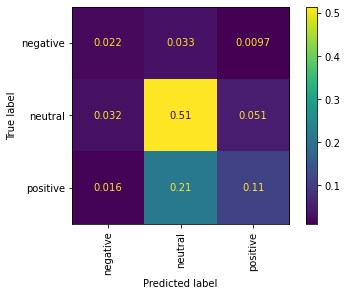

In [83]:
plot_confusion_matrix(rf_gs, X_test, y_test, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

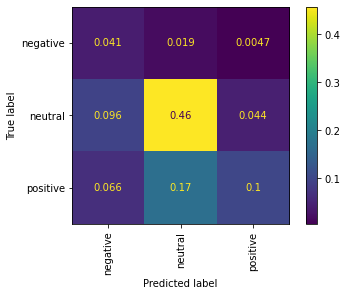

In [84]:
plot_confusion_matrix(tvc_gs, X_test, y_test, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);